In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import wfdb

import data_visualisation as dv

# Configurable variables

In [6]:
# data vars
path = 'physionet.org/files/ptb-xl/1.0.3/'
sampling_rate=100

# test train split using existing ptbxl folds
test_fold = 10
val_fold = 9

# Data Loading

In [3]:
# function to load data with wfdb
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# load and convert annotation data
DF = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
DF.scp_codes = DF.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
print('Loading data...')
X = load_raw_data(DF, sampling_rate, path)
print('Data loaded.')

# Load scp_statements.csv for diagnostic aggregation
print('Loading scp_statements...')
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print('Scp statements loaded.')

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
DF['diagnostic_superclass'] = DF.scp_codes.apply(aggregate_diagnostic)

#superclasses = np.unique([elem for sublist in DF.diagnostic_superclass for elem in sublist])


# Convert superclasses to binary matrix
Z = pd.DataFrame(0, index=DF.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in DF.loc[i].diagnostic_superclass:
        Z.loc[i, k] = 1

Loading data...


KeyboardInterrupt: 

# Create Test/Train/Validation Split

In [6]:
X_train = X[np.where(DF.strat_fold <= 8)]
y_train = Z[(DF.strat_fold <= 8)]
y_train_text = DF[(DF.strat_fold <= 8)].diagnostic_superclass

X_val = X[np.where(DF.strat_fold == val_fold)]
y_val = Z[DF.strat_fold == val_fold]

X_test = X[np.where(DF.strat_fold == test_fold)]
y_test = Z[DF.strat_fold == test_fold]

# Data Normalisation

In [56]:
from sklearn.preprocessing import StandardScaler

# Normalise data
X_scaler = StandardScaler()
X_scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

X_train = X_scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = X_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test  = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Save data in NumPy format

In [58]:
NP_DATA = f'data/PTB_XL_{sampling_rate}hz.npz'

save_args = {
    'X_train': X_train.astype(np.float32),
    'X_val': X_val.astype(np.float32),
    'X_test': X_test.astype(np.float32),
    'y_train': y_train.values.astype(np.float32),
    'y_train_text': y_train_text,
    'y_val': y_val.values.astype(np.float32),
    'y_test': y_test.values.astype(np.float32),
}

np.savez(NP_DATA, **save_args)

# Load and Visualise Data

In [4]:
NP_DATA = f'data/PTB_XL_{sampling_rate}hz.npz'
thismodule = sys.modules[__name__]

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if k == 'y_train_text':
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

Train data shape:  (17418, 1000, 12) Train labels shape:  (17418, 5) Train labels text shape:  (17418,)
Val data shape:  (2183, 1000, 12) Val labels shape:  (2183, 5)
Test data shape:  (2198, 1000, 12) Test labels shape:  (2198, 5)
Random sample:  12358
['NORM', 'MI', 'STTC', 'CD', 'HYP']
Labels:  [0. 1. 0. 0. 0.]
Labels:  ['MI']


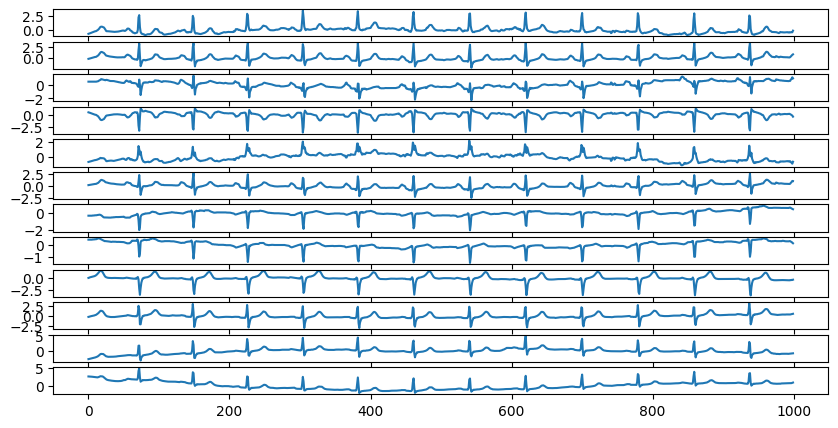

In [11]:
print('Train data shape: ', X_train.shape, 'Train labels shape: ', y_train.shape, 'Train labels text shape: ', y_train_text.shape)
print('Val data shape: ', X_val.shape, 'Val labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape, 'Test labels shape: ', y_test.shape)

rand_sample_i = random.randint(0, X_train.shape[0])
print('Random sample: ', rand_sample_i)
rand_sample = X_train[rand_sample_i]

bar, axes = plt.subplots(rand_sample.shape[1], 1, figsize=(10,5))
for i in range(rand_sample.shape[1]):
    sns.lineplot(x=np.arange(rand_sample.shape[0]), y=rand_sample[:, i], ax=axes[i])

print(['NORM', 'MI', 'STTC', 'CD', 'HYP'])
print('Labels: ', y_train[rand_sample_i])
print('Labels: ', y_train_text[rand_sample_i])

# Extracting Beats from the data

In [15]:
# initialise new arrays
X_HB = []
Z_HB = []
Z_HB_text = []
Samp_og_HB = []
Strat_og_HB = []

window_size = int(sampling_rate * 0.5)

# iterate over each 10s ECG
for i, sample in enumerate(X):
    print("Progress:", i, "/", X.shape[0], end="\r")
    xqrs = processing.XQRS(sig=sample[:,0], fs=sampling_rate)
    xqrs.detect(verbose=False)
    qrs_inds = xqrs.qrs_inds
    for indx in qrs_inds:
        if indx + window_size > sample.shape[0] or indx - window_size < 0:
            continue
        X_HB.append(sample[indx-window_size:indx+window_size])
        Z_HB.append(Z.iloc[i])
        Z_HB_text.append(DF.iloc[i].diagnostic_superclass)
        Samp_og_HB.append(i)
        Strat_og_HB.append(DF.iloc[i].strat_fold)
    
X_HB = np.array(X_HB)
Z_HB = np.array(Z_HB)
    
print(X_HB.shape)
print(Z_HB.shape)
        


35
(297385, 70, 12)/ 21799
(297385, 5)


Heartbeat data shape:  (288369, 100, 12) Heartbeat labels shape:  (288369, 5) Heartbeat labels text shape:  (288369,)


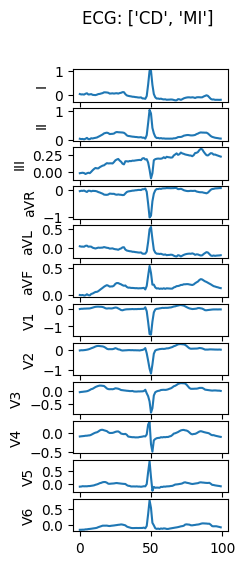

Classes: ['NORM', 'MI', 'STTC', 'CD', 'HYP']
Labels:  [0. 1. 0. 1. 0.]
Labels:  ['CD', 'MI']


In [4]:
print('Heartbeat data shape: ', X_HB.shape, 'Heartbeat labels shape: ', Z_HB.shape, 'Heartbeat labels text shape: ', Z_HB_text.shape)

# get random sample
rand_sample_i = np.random.randint(0, X_HB.shape[0])
rand_sample = X_HB[rand_sample_i]
rand_sample_label = Z_HB[rand_sample_i]
rand_sample_label_text = Z_HB_text[rand_sample_i]

dv.plot_12_lead_ecg(rand_sample, rand_sample_label_text)
    
print("Classes:",['NORM', 'MI', 'STTC', 'CD', 'HYP'])
print('Labels: ', rand_sample_label)
print('Labels: ', rand_sample_label_text)

In [7]:
X_train = X_HB[np.where(Strat_og_HB <= 8)]
y_train = Z_HB[(Strat_og_HB <= 8)]
y_train_text =Z_HB_text[(Strat_og_HB <= 8)]

X_val = X_HB[np.where(Strat_og_HB == val_fold)]
y_val = Z_HB[Strat_og_HB == val_fold]

X_test = X_HB[np.where(Strat_og_HB == test_fold)]
y_test = Z_HB[Strat_og_HB == test_fold]

print('Train data shape: ', X_train.shape, 'Train labels shape: ', y_train.shape, 'Train labels text shape: ', y_train_text.shape)

Train data shape:  (229753, 100, 12) Train labels shape:  (229753, 5) Train labels text shape:  (229753,)


# Save segmented data

In [8]:
np.savez('data/PTB_XL_HB_1s_window.npz', X_train=X_train, X_val=X_val, X_test=X_test, Y_train=y_train, Y_train_text=y_train_text, Y_val=y_val, Y_test=y_test)

In [9]:
# def bideriectional lstm model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics

def bi_lstm_model(X, num_classes=5, units=128):
    
    X = keras.layers.Bidirectional(keras.layers.LSTM(units, return_sequences=True))(X)
    X = keras.layers.Conv1D(64, 3, activation='relu')(X)
    X = keras.layers.MaxPooling1D(2)(X)
    X = keras.layers.Conv1D(16, 3, activation='relu')(X)
    X = keras.layers.GlobalAveragePooling1D()(X)
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dense(num_classes, activation='sigmoid')(X)
    
    return X

num_classes = 5
X_input = keras.Input(shape=X_train.shape[1:])
model_3 = bi_lstm_model(X_input, num_classes=num_classes)
model_3 = keras.Model(inputs=X_input, outputs=model_3)
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model_3.summary()

2024-05-23 14:50:03.247496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 14:50:03.797820: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-23 14:50:03.797887: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-23 14:50:03.797895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

KeyboardInterrupt: 

# WANDB Integration

In [73]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 1hraaif (raaif). Use `wandb login --relogin` to force relogin


True

In [78]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'test_binary_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [10]
        },
        'batch_size': {
            'values': [64, 128]
        },
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'kernel_size': {
            'values': [3, 5, 7]
        },
        'filters': {
            'values': [16, 32, 64]
        },
        'layers': {
            'values': [2, 4, 6]
        },
        'hidden_units': {
            'values': [64, 128, 256]
        }
    }
}

In [79]:
def train():
    wandb.init()
    config = wandb.config
    
    num_classes = 5
    X_input = keras.Input(shape=X_train.shape[1:])
    outputs2, feature_output2 = resnet_model(X_input, num_classes=num_classes, filters=config.filters, kernels=config.kernel_size, layers=config.layers, hidden_units=config.hidden_units)

    model2 = keras.Model(inputs=X_input, outputs=outputs2)
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
    model2.summary()
    
    model2.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val))
    
    # evaluate model
    test_loss, test_acc, test_prec, test_rec, test_bin_acc = model2.evaluate(X_test, y_test, verbose=2)
    wandb.log({'test_accuracy': test_acc, 'test_precision': test_prec, 'test_recall': test_rec, 'test_binary_accuracy': test_bin_acc})

In [80]:
sweep_id = wandb.sweep(sweep_config, project='ECG_Heartbeat_Classification')


Create sweep with ID: 4eud54zw
Sweep URL: https://wandb.ai/raaif/ECG_Heartbeat_Classification/sweeps/4eud54zw


In [81]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: 5y1sab8u with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	filters: 16
wandb: 	hidden_units: 128
wandb: 	kernel_size: 7
wandb: 	layers: 4
wandb: 	learning_rate: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 12)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 194, 16)      1360        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 194, 16)     64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 194, 16)      0           ['batch_normalization[0][0]']